In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
def p_joint(theta, nheads, ntails, prior_alpha=3, prior_beta=3): # p(data, theta)
    f = theta ** (nheads + prior_alpha - 1) * (1 - theta) **(ntails + prior_beta - 1) / special.beta(prior_alpha, prior_beta)
    neg_log_joint = - (nheads + prior_alpha - 1) * np.log(theta) \
                    - (ntails + prior_beta - 1) * np.log (1-theta) \
                    + np.log(special.beta(prior_alpha, prior_beta))
    return f, neg_log_joint

def grad(theta, nheads, ntails, prior_alpha=3, prior_beta=3):
    """ theta is a maximal point """
    g = - (nheads + prior_alpha - 1) / (theta) + (ntails + prior_beta - 1) / (1-theta)
    return g 

def hessian(theta, nheads, ntails, prior_alpha=3, prior_beta=3):
    """ theta is the scaled map """
    h = (nheads + prior_alpha - 1) / (theta**2)  + (ntails + prior_beta - 1) / (1-theta)**2
    return h
    

In [3]:
ntails = 10
nheads = 1

prior_alpha=3
prior_beta=3

theta_hat = (nheads + prior_alpha - 1) / (nheads + prior_alpha - 1 + ntails + prior_beta - 1)
sig2inv = hessian(theta_hat, nheads, ntails, prior_alpha, prior_beta)
sig2 = 1. / sig2inv
print(theta_hat, sig2inv, sig2)

0.2 93.74999999999999 0.010666666666666668


In [4]:
q = stats.norm(theta_hat, np.sqrt(sig2))
posterior_symb = stats.beta(nheads + prior_alpha, ntails + prior_beta)

0, ymin=0, ymax=4.002222325104642


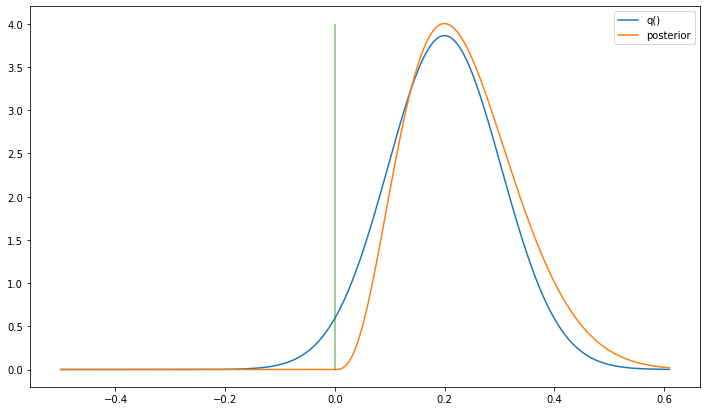

In [5]:
th = np.linspace(-.5, .61, 501)
# qvals = q.pdf(th)
plt.figure(figsize=(12,7))
plt.plot(th, q.pdf(th), label="q()")
plt.plot(th, posterior_symb.pdf(th), label="posterior")
print(f"0, ymin=0, ymax={posterior_symb.pdf(theta_hat)}")
plt.vlines(0, ymin=0, ymax=posterior_symb.pdf(theta_hat), color='g', alpha=.5)
plt.legend();

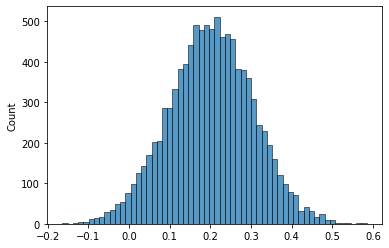

In [6]:
samples = q.rvs(10000)
sns.histplot(samples);

# Logit Transformation
$$ 
    \psi = \log\frac{\theta}{1 - \theta} 
$$
$$
    \theta = \frac{1}{1 + \exp(-x)}
$$

In [7]:
def sgm(x): # sigmoid
    return 1./ (1 + np.exp(-x))
def logit(x):
    return np.log(x/(1-x))

In [8]:
# p(\psi, data) = p(\theta, data) | d\theta_d\psi |

def p_theta(th, nheads, ntails, prior_alpha, prior_beta): # joint
    pj, neglog = p_joint(th, nheads=nheads, ntails=ntails, prior_alpha=prior_alpha, prior_beta=prior_beta)
    return pj

def p_psi(psi):  # joint in psi domain
    th = sgm(psi)
    J = sgm(psi) * (1 - sgm(psi)) # Jacobian or grad
    f = p_theta(th, nheads, ntails, prior_alpha, prior_beta) * J
    return f 

def posterior_psi(psi):
    th = sgm(psi)
    J = sgm(psi) * (1 - sgm(psi)) # Jacobian or grad
    f = stats.beta(nheads + prior_alpha, ntails + prior_beta).pdf(th) * J 
    return f 

def get_psi_hat():
    h = logit( (nheads + prior_alpha) / (nheads + prior_alpha + ntails + prior_beta) )
    return h 

def p_psi_hessian(psi_hat):
    h = (nheads + prior_alpha + ntails + prior_beta) * sgm(psi_hat) *(1-sgm(psi_hat))
    return h 

In [9]:
nheads + prior_alpha, ntails + prior_beta

(4, 13)

In [10]:
psi_hat = get_psi_hat()
sigma = 1. / np.sqrt(p_psi_hessian(psi_hat))
print(psi_hat, sigma, np.log(4./13))

-1.1786549963416462 0.5717718748968657 -1.1786549963416462


In [11]:
q = stats.norm(psi_hat, sigma)

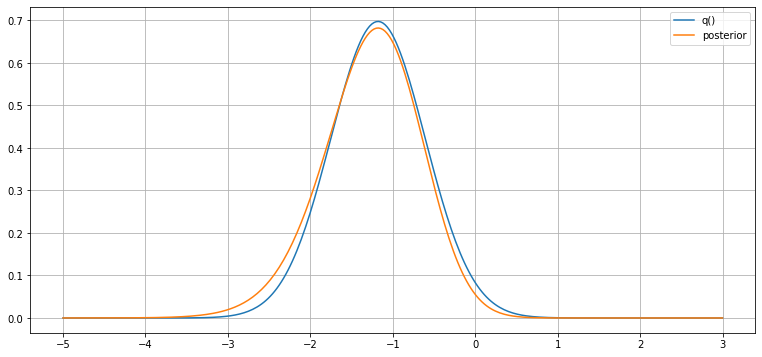

In [12]:
psi = np.linspace(-5, 3, 300)
plt.figure(figsize=(13,6))
plt.plot(psi, q.pdf(psi), label="q()")
plt.plot(psi, posterior_psi(psi), label="posterior")
plt.grid(True)
plt.legend();

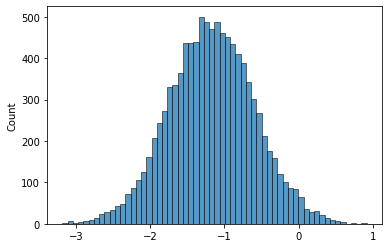

In [13]:
# sample in the logit space
psi_samples = stats.norm(psi_hat, sigma).rvs(10000)
sns.histplot(psi_samples);

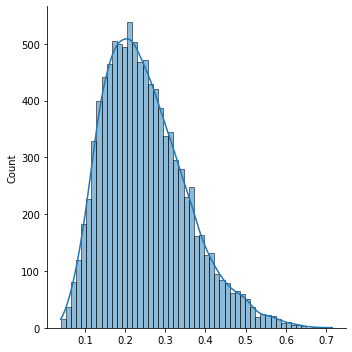

In [14]:
theta_samples = sgm(psi_samples)
sns.displot(theta_samples, kde=True);

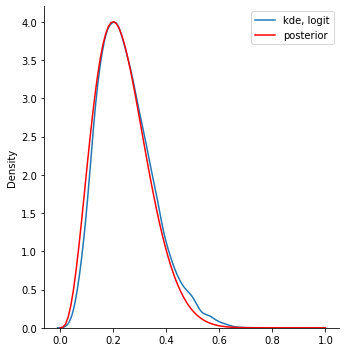

In [15]:
th = np.linspace(0,1,100)

sns.displot(theta_samples, kind='kde', label='kde, logit')
plt.plot(th, posterior_symb.pdf(th), label='posterior', color='r');
plt.legend();

End.